In [80]:
import sympy as sym
import numpy as np
import scipy as sp
from scipy import linalg,spatial,signal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Maybe solar panels structures

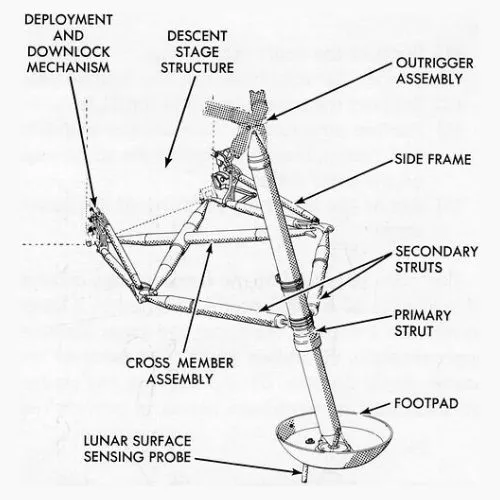

https://apollo11space.com/nasas-apollo-11-lunar-module-basic-facts/

## Osnovna (skupna) geometrija

(6, 2)
(5, 2)


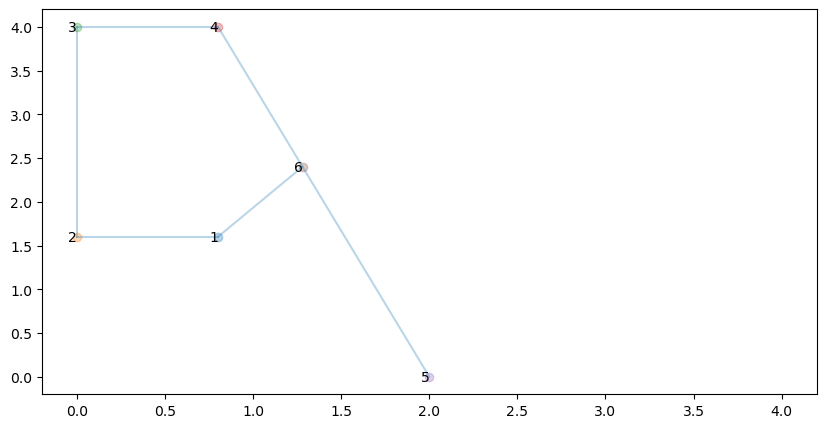

In [81]:
L1 = 2 # m - dolžina
L2 = 4 # m - višina
k1 = 0.4
k2 = 0.4
vozlisca_osn_sk = np.array([[k1 * L1, k2 * L2], [0, k2*L2], [0,L2], [k1 * L1, L2], [L1, 0]])

# Dolocitev vmesnega vozlisca
k3 = 0.6
y_P = k3*L2
x_P = (k3*(k1-1) +1)*L1
vozlisca_osn_sk = np.append(vozlisca_osn_sk, [x_P, y_P])
elementi_osn_sk = np.array([[0,1],[1,2], [2, 3], [3, 4], [0,5]])
vozlisca_osn_sk = vozlisca_osn_sk.reshape(6, 2)

# Izris
fig, ax = plt.subplots(figsize = (10, 5))
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.3)

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.3)
[plt.text(*c,n+1) for n,c in enumerate(vozlisca_osn_sk-0.05)];

ax.set_xlim(-0.2, 4.2)
ax.set_ylim(-0.2, 4.2)
print(vozlisca_osn_sk.shape)   # Output: (3, 2)
print(elementi_osn_sk.shape)

In [82]:
def zgostitev(vozlisca_osn, elementi_osn, number_of_elements = [2]):
    
    # V primeru, ko so vsi 
    if len(number_of_elements) == 1:
        
        vozlisca = np.copy(vozlisca_osn)
        elementi = np.empty((0,2), int)
        
        for i in elementi_osn: 
            x = np.linspace(vozlisca[i[0],0], vozlisca_osn[i[1],0], number_of_elements[0] + 1)[1:-1]
            y = np.linspace(vozlisca[i[0],1], vozlisca_osn[i[1],1], number_of_elements[0] + 1)[1:-1]
            voz = np.column_stack((x, y))
            
            novi_ind_vozlisc = len(vozlisca) + np.arange(len(voz))
            vozlisca = np.append(vozlisca, voz, axis = 0)
            sez_voz = np.block([i[0],novi_ind_vozlisc,i[1]])
            elem = np.array([[sez_voz[_],sez_voz[_+1]] for _ in range(len(sez_voz)-1)])
            elementi = np.append(elementi, elem, axis = 0)
        return (vozlisca, elementi)
    
    elif len(number_of_elements) == len(elementi_osn):
        vozlisca = np.copy(vozlisca_osn)
        elementi = np.empty((0,2), int)
        
        for j in np.arange(len(elementi_osn)):
            x = np.linspace(vozlisca[elementi_osn[j][0],0], vozlisca_osn[elementi_osn[j][1],0], 1 + int(number_of_elements[j]))[1:-1]
            y = np.linspace(vozlisca[elementi_osn[j][0],1], vozlisca_osn[elementi_osn[j][1],1], 1 + int(number_of_elements[j]))[1:-1]
            voz = np.column_stack((x, y))
        
            novi_ind_vozlisc = len(vozlisca) + np.arange(len(voz))
            vozlisca = np.append(vozlisca, voz, axis = 0)
            sez_voz = np.block([elementi_osn[j][0], novi_ind_vozlisc, elementi_osn[j][1]])
            elem = np.array([[sez_voz[_],sez_voz[_+1]] for _ in range(len(sez_voz)-1)])
            elementi = np.append(elementi, elem, axis = 0)
        return (vozlisca, elementi)
    # return(vozlisca, elementi)
    
    else:
        print("Error!")
        print("To many numbers of elements - Array to long")

In [83]:
# OKVIR
# transformacijska matrika
def T(α):
    
    T = np.array([[ np.cos(α), np.sin(α), 0,         0,         0, 0],
                   [-np.sin(α), np.cos(α), 0,         0,         0, 0],
                   [         0,         0, 1,         0,         0, 0],
                   [         0,         0, 0, np.cos(α), np.sin(α), 0],
                   [         0,         0, 0,-np.sin(α), np.cos(α), 0],
                   [         0,         0, 0,         0,         0, 1]])
        
    return T

# masna matrika
def M_o(A, L, ρ, α):

    M_lok = ρ*A*L*np.array([[1/3,         0,         0, 1/6,         0,         0],
                            [  0,     13/35,  11*L/210,   0,      9/70, -13*L/420],
                            [  0,  11*L/210,  L**2/105,   0,  13*L/420, -L**2/140],
                            [1/6,         0,         0, 1/3,         0,         0],
                            [  0,      9/70,  13*L/420,   0,     13/35, -11*L/210],
                            [  0, -13*L/420, -L**2/140,   0, -11*L/210,  L**2/105]])
    
    return T(α).T @ M_lok @ T(α)

# togostna matrika
def K_o(A, E, I, L, α):

    K_lok = E/L*np.array([[ A,          0,      0, -A,          0,      0],
                          [ 0,  12*I/L**2,  6*I/L,  0, -12*I/L**2,  6*I/L],
                          [ 0,      6*I/L,    4*I,  0,     -6*I/L,    2*I],
                          [-A,          0,      0,  A,          0,      0],
                          [ 0, -12*I/L**2, -6*I/L,  0,  12*I/L**2, -6*I/L],
                          [ 0,      6*I/L,    2*I,  0,     -6*I/L,    4*I]])
    
    return T(α).T @ K_lok @ T(α)

In [ ]:
# PALIČJE

# masna matrika
def M_p(A, L, ρ):

    M = ρ*A*L/6*np.array([
    [2, 0, 1, 0],
    [0, 2, 0, 1],
    [1, 0, 2, 0],
    [0, 1, 0, 2]])
    
    return M

def K_p(A, E, L, α):

    c = np.cos(α)
    s = np.sin(α)
    
    K = A*E/L*np.array([
    [ c**2,   s*c, -c**2,  -s*c],
    [  s*c,  s**2,  -s*c, -s**2],
    [-c**2,  -s*c,  c**2,   s*c],
    [ -c*s, -s**2,   s*c,  s**2]])
    
    return K

## Struktura 1

In [84]:
vozlisca_osn_A = vozlisca_osn_sk[:4]
elementi_osn_A = elementi_osn_sk[:3]
# vozlisca_osn_A

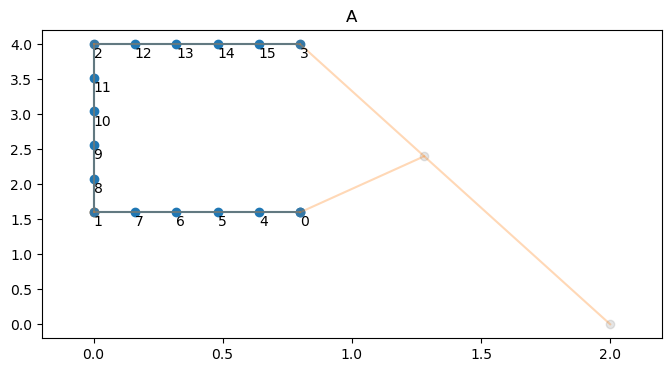

In [85]:
# vozlisca_osn_A = vozlisca_osn_A.reshape(6, 2)

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("A")
for i in vozlisca_osn_A[:-2]:
    ax.plot(i[0], i[1], 'o')

for element in elementi_osn_A:
    x = [vozlisca_osn_A[element[0], 0], vozlisca_osn_A[element[1], 0]]
    y = [vozlisca_osn_A[element[0], 1], vozlisca_osn_A[element[1], 1]]
    ax.plot(x, y, 'C0')


ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)

vozlisca_A, elementi_A = zgostitev(vozlisca_osn_A, elementi_osn_A, [5, 5, 5])

for i in np.arange(len(vozlisca_A)):
    ax.plot(vozlisca_A[i][0], vozlisca_A[i][1], 'o', color='C0')
[ax.text(*c,n) for n,c in enumerate(vozlisca_A-[0, 0.2])];

# Izris backup strukture
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.2, color="gray")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C1', alpha=0.3)

In [86]:
# Podstruktura A - okvir

h = 0.005 # m
D = 0.2 # m
d = D-2*h

ρ_A = 2700 # kg /m3
E_A = 100e9 # Pa recimo nek specialen Al

A_A = np.pi * ((D/2)**2 - (D/2-h)**2)
I_A = np.pi/4 * (D**4 - d**4)
# Votli okrogli profil


# zlaganje
n_ps_A = 3*len(vozlisca_A)
M_glob_A = np.zeros((n_ps_A,n_ps_A))
K_glob_A = np.zeros((n_ps_A,n_ps_A))

for element in elementi_A:
    Le = sp.spatial.distance.euclidean(vozlisca_A[element[0]], vozlisca_A[element[1]])
    αe = np.arctan2(np.diff(vozlisca_A[element,1]) , np.diff(vozlisca_A[element,0]))[0]
    ind = (3*element[:,None] + np.array([0, 1, 2])).flatten()
    
    M_glob_A[ind[:,None],ind] += M_o(A_A, Le, ρ_A, αe)
    K_glob_A[ind[:,None],ind] += K_o(A_A, E_A, I_A, Le, αe)


print(f'Stevilo osnovnih vozlisc: \t {len(vozlisca_osn_A)}')
print(f'Stevilo osnovnih elementov: \t {len(elementi_osn_A)}')
print(f'Stevilo zgoscenih vozlisc: \t {len(vozlisca_A)}')
print(f'Stevilo zgoscenih elementov: \t {len(elementi_A)}')
print(f'Oblika vozlisca_A : {vozlisca_A.shape}, oblika elementi_A: {elementi_A.shape}')
print(f'Oblika vozlisca_osn_A : {vozlisca_osn_A.shape}, oblika elementi_osn_A: {elementi_osn_A.shape}')
print()
print(f'M_glob_A : {M_glob_A.shape}, \t K_glob_A: {K_glob_A.shape}')

Stevilo osnovnih vozlisc: 	 4
Stevilo osnovnih elementov: 	 3
Stevilo zgoscenih vozlisc: 	 16
Stevilo zgoscenih elementov: 	 15
Oblika vozlisca_A : (16, 2), oblika elementi_A: (15, 2)
Oblika vozlisca_osn_A : (4, 2), oblika elementi_osn_A: (3, 2)

M_glob_A : (48, 48), 	 K_glob_A: (48, 48)


## Struktura 2 (C)

In [87]:
vozlisca_osn_C = vozlisca_osn_sk[-3:-1]
elementi_osn_C = np.array([[0,1]])
vozlisca_osn_C = vozlisca_osn_C.reshape(2, 2)

Stevilo osnovnih vozlisc: 	 2
Stevilo osnovnih elementov: 	 1
Stevilo zgoscenih vozlisc: 	 21
Stevilo zgoscenih elementov: 	 20
Oblika vozlisca_C : (21, 2), oblika elementi_C: (20, 2)
Oblika vozlisca_osn_C : (2, 2), oblika elementi_osn_C: (1, 2)

M_glob_C : (63, 63), 	 K_glob_C: (63, 63)


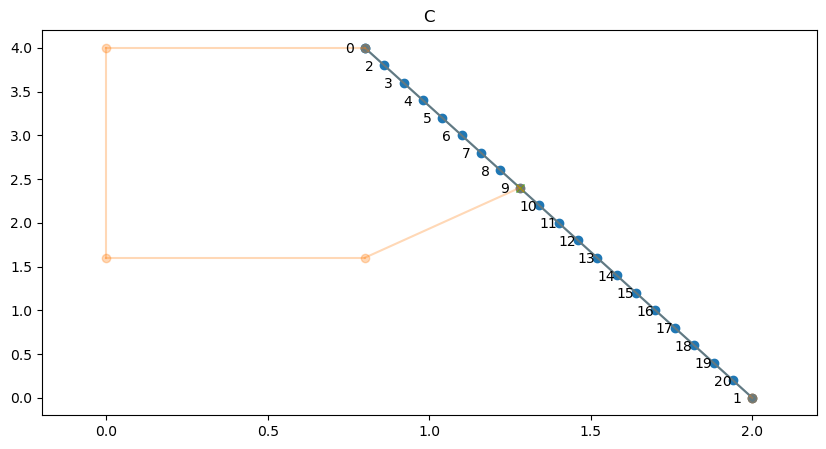

In [88]:
# Figure
fig, ax = plt.subplots(figsize = (10, 5))
ax.set_title("C")

for i in vozlisca_osn_C:
    ax.plot(i[0], i[1], 'o')

for element in elementi_osn_C:
    x = [vozlisca_osn_C[element[0], 0], vozlisca_osn_C[element[1], 0]]
    y = [vozlisca_osn_C[element[0], 1], vozlisca_osn_C[element[1], 1]]
    ax.plot(x, y, 'C0')

ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)


vozlisca_C, elementi_C = zgostitev(vozlisca_osn_C[:], elementi_osn_C, [20])


for i in np.arange(len(vozlisca_C)):
    ax.plot(vozlisca_C[i][0], vozlisca_C[i][1], 'o', color='C0')
[ax.text(*c, n) for n,c in enumerate(vozlisca_C  - 0.06)];
ax.plot(vozlisca_C[9][0], vozlisca_C[9][1], 'x')

for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.3, color="C1")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C1', alpha=0.3)


# Podstruktura C - okvir

h = 0.005 # m
D = 0.25 # m
d = D-2*h

ρ_C = 2700 # kg /m3
E_C = 100e9 # Pa recimo nek specialen Al

A_C = np.pi * ((D/2)**2 - (D/2-h)**2)
I_C = np.pi/4 * (D**4 - d**4)

# zlaganje
n_ps_C = 3*len(vozlisca_C)
M_glob_C = np.zeros((n_ps_C,n_ps_C))
K_glob_C = np.zeros((n_ps_C,n_ps_C))

for element in elementi_C:
    Le = sp.spatial.distance.euclidean(vozlisca_C[element[0]], vozlisca_C[element[1]])
    αe = np.arctan2(np.diff(vozlisca_C[element,1]) , np.diff(vozlisca_C[element,0]))[0]
    ind = (3*element[:,None] + np.array([0, 1, 2])).flatten()
    
    M_glob_C[ind[:,None],ind] += M_o(A_C, Le, ρ_C, αe)
    K_glob_C[ind[:,None],ind] += K_o(A_C, E_C, I_C, Le, αe)
    


print(f'Stevilo osnovnih vozlisc: \t {len(vozlisca_osn_C)}')
print(f'Stevilo osnovnih elementov: \t {len(elementi_osn_C)}')
print(f'Stevilo zgoscenih vozlisc: \t {len(vozlisca_C)}')
print(f'Stevilo zgoscenih elementov: \t {len(elementi_C)}')
print(f'Oblika vozlisca_C : {vozlisca_C.shape}, oblika elementi_C: {elementi_C.shape}')
print(f'Oblika vozlisca_osn_C : {vozlisca_osn_C.shape}, oblika elementi_osn_C: {elementi_osn_C.shape}')
print()
print(f'M_glob_C : {M_glob_C.shape}, \t K_glob_C: {K_glob_C.shape}')

## Struktura 3 (B)

In [90]:
# Na katero vozlišče se pripenja naša palica (B)
indeks_C = 9;
print(f'Vozlišče \t x\t y')
print(f'{indeks_C} \t\t{vozlisca_C[indeks_C][0]:.2f}\t{vozlisca_C[indeks_C][1]:.2f} ')
vozlisca_osn_B = np.hstack((vozlisca_osn_sk[0], vozlisca_C[indeks_C])).reshape(2, 2)
elementi_osn_B = np.array([[0,1]])

vozlisca_B, elementi_B = zgostitev(vozlisca_osn_B[:], elementi_osn_B, [1])

Vozlišče 	 x	 y
9 		1.28	2.40 


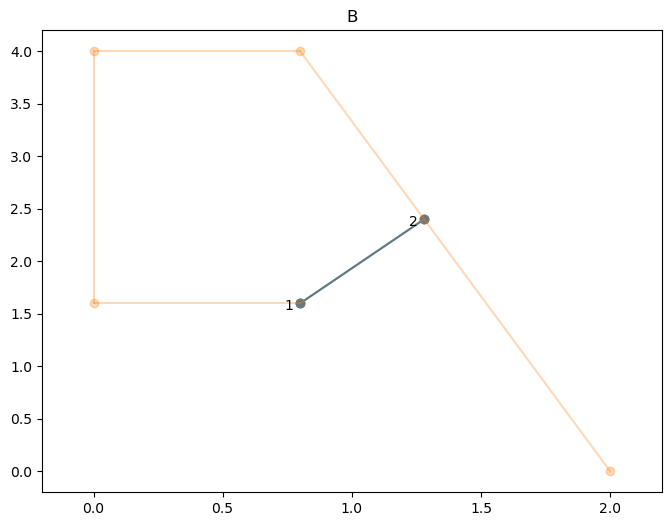

In [91]:
# Figure
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title("B")
for i in vozlisca_osn_B:
    ax.plot(i[0], i[1], 'o')

for element in elementi_osn_B:
    x = [vozlisca_osn_B[element[0], 0], vozlisca_osn_B[element[1], 0]]
    y = [vozlisca_osn_B[element[0], 1], vozlisca_osn_B[element[1], 1]]
    ax.plot(x, y, 'C0')
# [ax.text(*c,n+1) for n,c in enumerate(vozlisca_osn_B-0.05)]
ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
for i in np.arange(len(vozlisca_B)):
    ax.plot(vozlisca_B[i][0], vozlisca_B[i][1], 'o', color='C0')
[ax.text(*c, n+1) for n,c in enumerate(vozlisca_B  - 0.06)];

# Izris backup strukture
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.3, color="C1")

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C1', alpha=0.3)



In [92]:
# Podstruktura B - paličje

# φ = 0*np.pi/4 # rad
d = 0.010 # m

ρ_B = 7800 # kg /m3
E_B = 210e9 # Pa
A_B = np.pi * d**2 / 4 # m^2

# zlaganje
n_ps_B = 2*len(vozlisca_B)
M_glob_B = np.zeros((n_ps_B,n_ps_B))
K_glob_B = np.zeros((n_ps_B,n_ps_B))

for element in elementi_B:
    Le = sp.spatial.distance.euclidean(vozlisca_B[element[0]], vozlisca_B[element[1]])
    αe = np.arctan2(np.diff(vozlisca_B[element,1]) , np.diff(vozlisca_B[element,0]))[0]
    ind = (2*element[:,None] + np.array([0, 1])).flatten()
    
    M_glob_B[ind[:,None],ind] += M_p(A_B, Le, ρ_B)
    K_glob_B[ind[:,None],ind] += K_p(A_B, E_B, Le, αe)


print(f'Stevilo osnovnih vozlisc: \t {len(vozlisca_osn_B)}')
print(f'Stevilo osnovnih elementov: \t {len(elementi_osn_B)}')
print(f'Stevilo zgoscenih vozlisc: \t {len(vozlisca_B)}')
print(f'Stevilo zgoscenih elementov: \t {len(elementi_B)}')
print(f'Oblika vozlisca_B : {vozlisca_B.shape}, oblika elementi_B: {elementi_B.shape}')
print(f'Oblika vozlisca_osn_B : {vozlisca_osn_B.shape}, oblika elementi_osn_B: {elementi_osn_B.shape}')

Stevilo osnovnih vozlisc: 	 2
Stevilo osnovnih elementov: 	 1
Stevilo zgoscenih vozlisc: 	 2
Stevilo zgoscenih elementov: 	 1
Oblika vozlisca_B : (2, 2), oblika elementi_B: (1, 2)
Oblika vozlisca_osn_B : (2, 2), oblika elementi_osn_B: (1, 2)


## Skupna geometrija

(6, 2)
(5, 2)


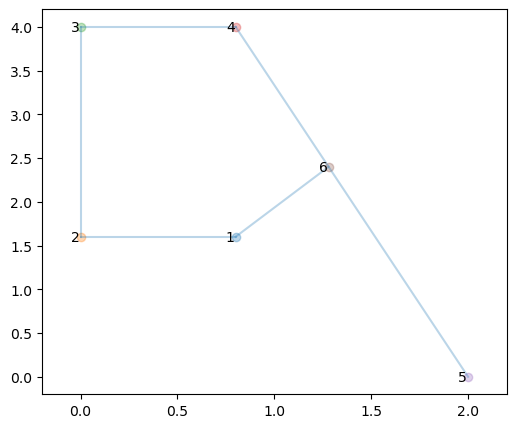

In [93]:
fig, ax = plt.subplots(figsize = (6, 5))
for i in vozlisca_osn_sk:
    ax.plot(i[0], i[1], 'o', alpha=0.3)

for element in elementi_osn_sk:
    x = [vozlisca_osn_sk[element[0], 0], vozlisca_osn_sk[element[1], 0]]
    y = [vozlisca_osn_sk[element[0], 1], vozlisca_osn_sk[element[1], 1]]
    ax.plot(x, y, 'C0', alpha=0.3)
[plt.text(*c,n+1) for n,c in enumerate(vozlisca_osn_sk-0.05)];

ax.set_xlim(-0.2, 2.2)
ax.set_ylim(-0.2, 4.2)
print(vozlisca_osn_sk.shape)   # Output: (3, 2)
print(elementi_osn_sk.shape)

In [94]:
n_ps_C
print(3*indeks_C)
for i in np.arange(indeks_C+2):
    print(f'{i+1}:\t{3*i}, {3*i+1}, {3*i+2}')

27
1:	0, 1, 2
2:	3, 4, 5
3:	6, 7, 8
4:	9, 10, 11
5:	12, 13, 14
6:	15, 16, 17
7:	18, 19, 20
8:	21, 22, 23
9:	24, 25, 26
10:	27, 28, 29
11:	30, 31, 32


## Robni pogoji

In [132]:
# robni pogoji in povezava podstruktur

# A - robni pogoji
ind_vpetih_ps_A = np.array([3, 4, 6, 7])
C_A_rp = np.zeros((len(ind_vpetih_ps_A),n_ps_A))
C_A_rp[np.arange(len(ind_vpetih_ps_A)),ind_vpetih_ps_A] = 1 # Definiramo, katere PS so fiksne

# C - robni pogoji
ind_vpetih_ps_C = np.array([3, 4])
C_C_rp = np.zeros((len(ind_vpetih_ps_C),n_ps_C))
C_C_rp[np.arange(len(ind_vpetih_ps_C)),ind_vpetih_ps_C] = 1

# Zložimo skupaj A in C
C_rp_AC = sp.linalg.block_diag(C_A_rp, C_C_rp)

# Dodamo še prazne "stolpce" zaradi B-ja
C_rp_B = np.zeros((C_rp_AC.shape[0], n_ps_B))

# Sestavimo te tri (dva) skupaj
C_rp_ABC = np.c_[C_rp_AC[:, :n_ps_A], C_rp_B, C_rp_AC[:, -n_ps_C:]]
C_rp_ABC.shape

# A B C povezava

# A
C_A_pov = np.zeros((7,n_ps_A))
C_B_pov = np.zeros((7,n_ps_B))
C_C_pov = np.zeros((7,n_ps_C))

# Povezava A-C
C_A_pov[[0,1],[9, 10]] = 1                          # vozlisce indeks 3 x,y  (A)
C_C_pov[[0,1],[0,1]] = -1                           # vozlisce indeks 0 x,y  (C)

# A-B
# x
C_A_pov[[4],[0]] = -1                         # vozlisce indeks 3 x,y  (A)
C_B_pov[[4],[0]] = 1
# y
C_A_pov[[5],[1]] = -1                         # vozlisce indeks 3 x,y  (A)
C_B_pov[[5],[1]] = 1

# B-C
C_B_pov[[6,3],[2,3]] = 1                           # vozlisce indeks 1 x,y        (B)
C_C_pov[[6,3],[3*indeks_C, 3*indeks_C + 1]] = -1    # vozlisce indeks "indeks_C" x,y (C)


C_ABC_pov = np.hstack([C_A_pov, C_B_pov, C_C_pov]) 
C_pov_ABC1 = C_ABC_pov[:2, :] # np.hstack([C_A_pov[:2, :], C_B_pov[:2, :], C_C_pov[:2, :]]) 
C_pov_ABC2 = C_ABC_pov[3:5, :] # np.hstack([C_A_pov[3:5, :], C_B_pov[3:5, :], C_C_pov[3:5, :]]) 
C_pov_ABC3 = C_ABC_pov[-2:, :] # np.hstack([C_A_pov[-2:, :], C_B_pov[-2:, :], C_C_pov[-2:, :]]) 

# C_pov_ABC1.shape, C_pov_ABC2.shape, C_pov_ABC3.shape
# združeno
C = np.vstack([C_rp_ABC, C_pov_ABC1, C_pov_ABC2, C_pov_ABC3])
L_ABC = sp.linalg.null_space(C)

# združitev masne in togostne matrike
M_glob_ABC = L_ABC.T @ sp.linalg.block_diag(M_glob_A, M_glob_B, M_glob_C) @ L_ABC
K_glob_ABC = L_ABC.T @ sp.linalg.block_diag(K_glob_A, K_glob_B, K_glob_C) @ L_ABC
L_ABC.shape

(115, 103)

In [133]:
L_A = L_ABC[:n_ps_A, :]
L_B = L_ABC[n_ps_A:n_ps_A + n_ps_B, :]
L_C = L_ABC[-n_ps_C:, :]

In [134]:
# # Create the heatmap
# fig, ax = plt.subplots()
# ax.set_title("A")
# im = ax.imshow(C_A_pov)
# cbar = ax.figure.colorbar(im, ax=ax)
# plt.show()

# # Create the heatmap
# fig, ax = plt.subplots()
# ax.set_title("B")
# im = ax.imshow(C_B_pov)
# cbar = ax.figure.colorbar(im, ax=ax)
# plt.show()

# # Create the heatmap
# fig, ax = plt.subplots()
# ax.set_title("C")
# im = ax.imshow(C_C_pov)
# cbar = ax.figure.colorbar(im, ax=ax)
# plt.show()

A = np.arange(10)
A[1:3]
print(f'DoF A : {n_ps_A}')
print(f'DoF B : {n_ps_B}')
print(f'DoF C : {n_ps_C}')
print(f'Skupaj : {n_ps_A + n_ps_B + n_ps_C}')
print(f'L_ABC : {L_ABC.shape}')
print(f'{C_rp_ABC.shape}')
print(f'{C.shape}')
print()



# problem lastnih vrednosti
eig_val, eig_vec = sp.linalg.eig(K_glob_ABC, M_glob_ABC)

# urejanje po velikosti
_ind = np.argsort(np.abs(eig_val))
eig_val = np.abs(eig_val[_ind])
eig_vec = eig_vec[:,_ind]

eig_freq = np.abs(eig_val)**0.5 / 2 / np.pi

# interpretacija rezultata
# eig_vec_A = L_ABC[:n_ps_A,:] @ eig_vec
# eig_vec_B = L_ABC[n_ps_A:n_ps_A+n_ps_B,:] @ eig_vec
# eig_vec_C = L_ABC[-n_ps_C:,:] @ eig_vec

eig_vec_A = L_A @ eig_vec
eig_vec_B = L_B @ eig_vec
eig_vec_C = L_C @ eig_vec

# # Create the heatmap
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_title("C")
# im = ax.imshow(L_ABC[51:53,:])
# cbar = ax.figure.colorbar(im, ax=ax, location='bottom', orientation='horizontal')
# cbar.ax.set_xlabel('Colorbar Label', labelpad=1)
# plt.show()
print(f'{eig_vec_A.shape}, {eig_vec_B.shape}, {eig_vec_C.shape}')
print(f'Sum: {eig_vec_A.shape[0] + eig_vec_B.shape[0] + eig_vec_C.shape[0]}, L_ABC: {L_ABC.shape[0]}')
# lastne frekvence [Hz]
eig_freq[:20].round(1)

DoF A : 48
DoF B : 4
DoF C : 63
Skupaj : 115
L_ABC : (115, 103)
(6, 115)
(12, 115)

(48, 103), (4, 103), (63, 103)
Sum: 115, L_ABC: 115


array([ 204.2,  388.8,  558.8,  695.4, 1036.7, 1144. , 1272.5, 1288.8,
       1763.8, 1865.5, 1978.7, 2325.8, 2533.6, 2703.9, 3158.4, 3195.6,
       3873.8, 4348.9, 4415.6, 4451. ])

In [135]:
eig_vec.shape

(103, 103)

[1.34509275 2.10818853]
[1.34509275 2.10818853]
0
[0.79112766 1.77650106]
[0.79112766 1.77650106]


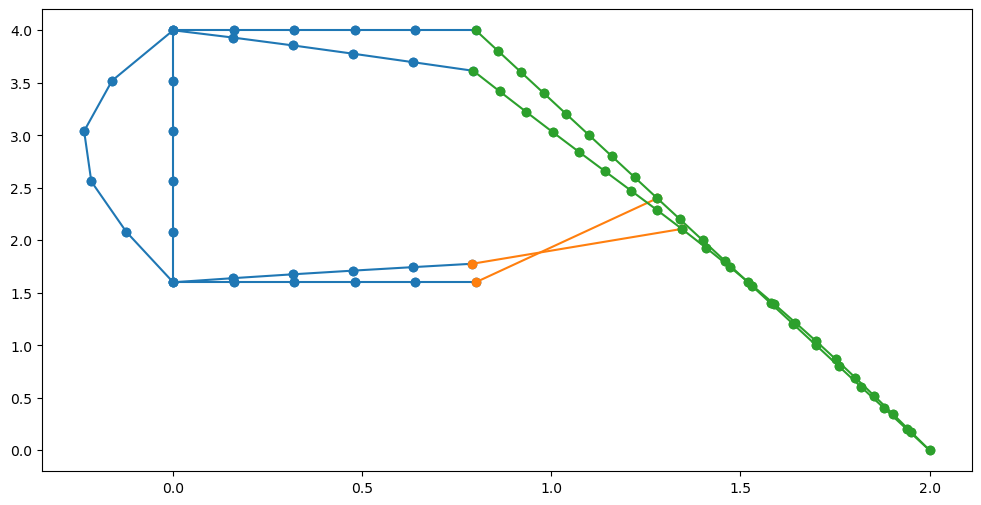

In [136]:
# animacija lastnih oblik
m = 1
s = 2 # scale faktor

# podstruktura A
pomiki_x_A = eig_vec_A[0::3, m].real
pomiki_y_A = eig_vec_A[1::3, m].real

# podstruktura C
pomiki_x_C = eig_vec_C[0::3, m].real
pomiki_y_C = eig_vec_C[1::3, m].real

# podstruktura B
pomiki_x_B = eig_vec_B[0::2, m].real
pomiki_y_B = eig_vec_B[1::2, m].real

# stacionarni izris A
def_vozlisca_A = np.copy(vozlisca_A)
def_vozlisca_A[:,0] += pomiki_x_A * s
def_vozlisca_A[:,1] += pomiki_y_A * s

# stacionarni izris C
def_vozlisca_C = np.copy(vozlisca_C)
def_vozlisca_C[:,0] += pomiki_x_C * s
def_vozlisca_C[:,1] += pomiki_y_C * s

# stacionarni izris B
def_vozlisca_B = np.copy(vozlisca_B)
def_vozlisca_B[:,0] += pomiki_x_B * s
def_vozlisca_B[:,1] += pomiki_y_B * s
 
fig, ax = plt.subplots(figsize = (12, 6))
# ax.set_xlim(0.2, 2.2)
# ax.set_ylim(1.2, 3.2)
[ax.plot(*vozlisca_A[e].T,'-o',c='C0') for e in elementi_A];
[ax.plot(*vozlisca_B[e].T,'-o',c='C1') for e in elementi_B];
[ax.plot(*vozlisca_C[e].T,'-o',c='C2') for e in elementi_C];

# deformirano stanje

[ax.plot(*def_vozlisca_A[e].T,'-o',c='C0') for e in elementi_A];
[ax.plot(*def_vozlisca_B[e].T,'-o',c='C1') for e in elementi_B];
[ax.plot(*def_vozlisca_C[e].T,'-o',c='C2') for e in elementi_C];

print(def_vozlisca_C[indeks_C, :])
print(def_vozlisca_B[1, :])

print("0")
print(def_vozlisca_A[0, :])
print(def_vozlisca_B[0, :])
# pomiki_x_B.shape, pomiki_y_B.shape
# def_vozlisca_B
# pomiki_x_B[0] == pomiki_y_C

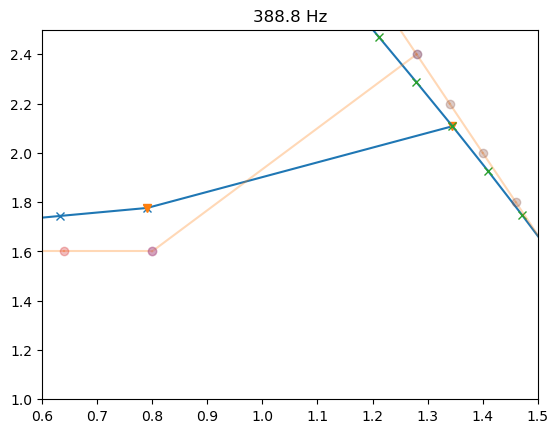

In [138]:
# podstruktura A
pomiki_x_A = eig_vec_A[0::3,m].real
pomiki_y_A = eig_vec_A[1::3,m].real

# podstruktura B
pomiki_x_B = eig_vec_B[0::2,m].real
pomiki_y_B = eig_vec_B[1::2,m].real

# podstruktura C
pomiki_x_C = eig_vec_C[0::3,m].real
pomiki_y_C = eig_vec_C[1::3,m].real

def_vozlisca_A = np.copy(vozlisca_A)
def_vozlisca_A[:,0] += pomiki_x_A *s
def_vozlisca_A[:,1] += pomiki_y_A * s

def_vozlisca_B = np.copy(vozlisca_B)
def_vozlisca_B[:,0] += pomiki_x_B *s
def_vozlisca_B[:,1] += pomiki_y_B * s

def_vozlisca_C = np.copy(vozlisca_C)
def_vozlisca_C[:,0] += pomiki_x_C *s
def_vozlisca_C[:,1] += pomiki_y_C * s

# Define the undeformed and deformed coordinates
undeformed_coords_A = vozlisca_A
deformed_coords_A = def_vozlisca_A

undeformed_coords_B = vozlisca_B
deformed_coords_B = def_vozlisca_B

undeformed_coords_C = vozlisca_C
deformed_coords_C = def_vozlisca_C

undeformed_coords = np.vstack((vozlisca_A, vozlisca_B, vozlisca_C))
deformed_coords = np.vstack((def_vozlisca_A, def_vozlisca_B, def_vozlisca_C))
# undeformed_coords.shape, deformed_coords.shape

# # Calculate the deformation array
deformation = np.array(deformed_coords) - np.array(undeformed_coords)
# deformation.shape

# # Define the number of frames for each deformation direction
n_frames = 20

# # Define the animation direction sequence
directions = [1, -1]

# # Create a figure and axis object
fig, ax = plt.subplots()
ax.set_title(f'{eig_freq[m].round(1)} Hz')
ax.set_xlim(0.6, 1.5)
ax.set_ylim(1, 2.5)


[ax.plot(deformed_coords_A[[i,j],0],deformed_coords_A[[i,j],1],'-',c='C0', alpha=1) for i,j in elementi_A]
ax.plot(deformed_coords_A[:,0],deformed_coords_A[:,1],'x', alpha=1);
[ax.plot(deformed_coords_B[[i,j],0],deformed_coords_B[[i,j],1],'-',c='C0', alpha=1) for i,j in elementi_B]
ax.plot(deformed_coords_B[:,0],deformed_coords_B[:,1],'v', alpha=1);
[ax.plot(deformed_coords_C[[i,j],0],deformed_coords_C[[i,j],1],'-',c='C0', alpha=1) for i,j in elementi_C]
ax.plot(deformed_coords_C[:,0],deformed_coords_C[:,1],'x', alpha=1);

[ax.plot(vozlisca_A[[i,j],0],vozlisca_A[[i,j],1],'-',c='C1', alpha=0.3) for i,j in elementi_A]
ax.plot(vozlisca_A[:,0],vozlisca_A[:,1],'o', alpha=0.3);
[ax.plot(vozlisca_B[[i,j],0],vozlisca_B[[i,j],1],'-',c='C1', alpha=0.3) for i,j in elementi_B]
ax.plot(vozlisca_B[:,0],vozlisca_B[:,1],'o', alpha=0.3);
[ax.plot(vozlisca_C[[i,j],0],vozlisca_C[[i,j],1],'-',c='C1', alpha=0.3) for i,j in elementi_C]
ax.plot(vozlisca_C[:,0],vozlisca_C[:,1],'o', alpha=0.3);

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


GIF 0 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 1 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 2 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 3 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 4 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 5 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 6 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 7 ustvarjen!


MovieWriter imagemagick unavailable; using Pillow instead.


GIF 8 ustvarjen!
GIF 9 ustvarjen!


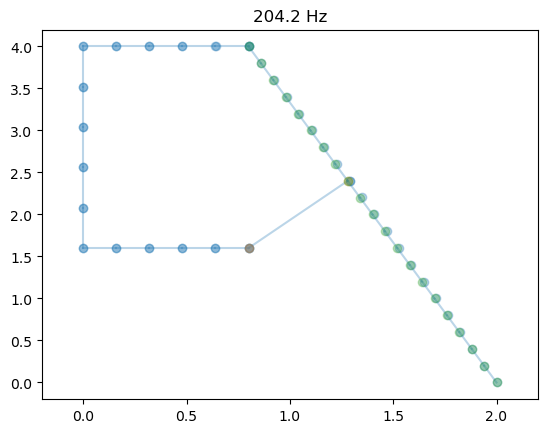

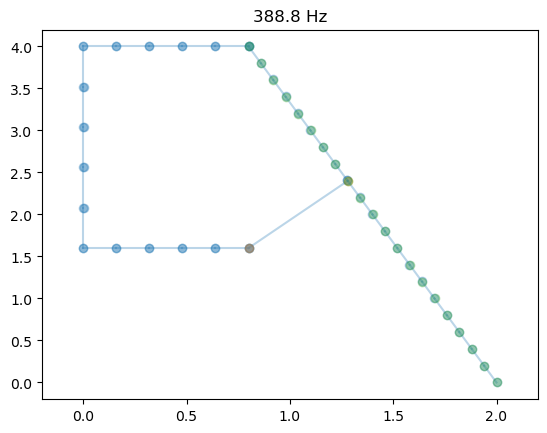

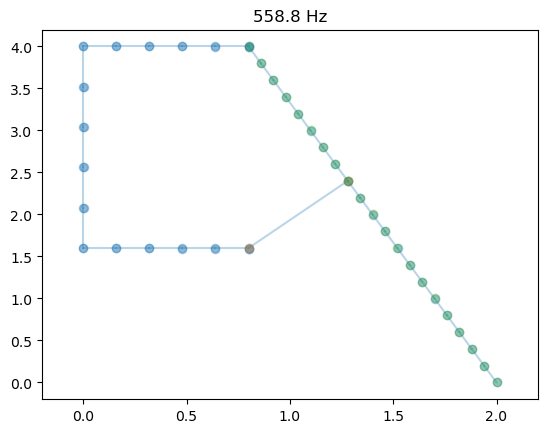

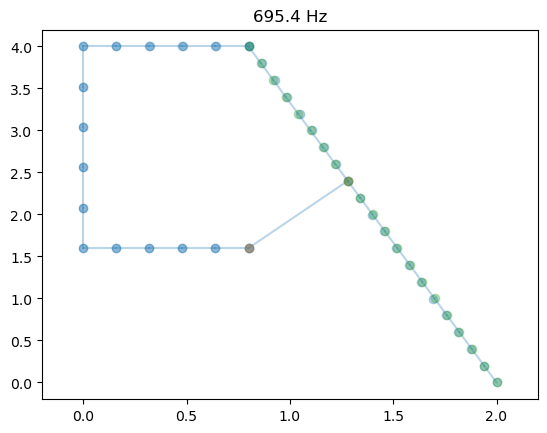

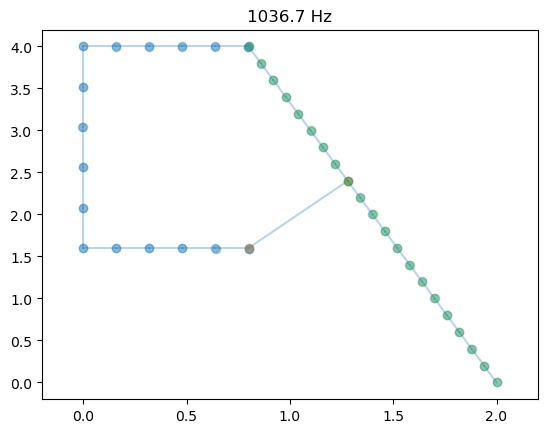

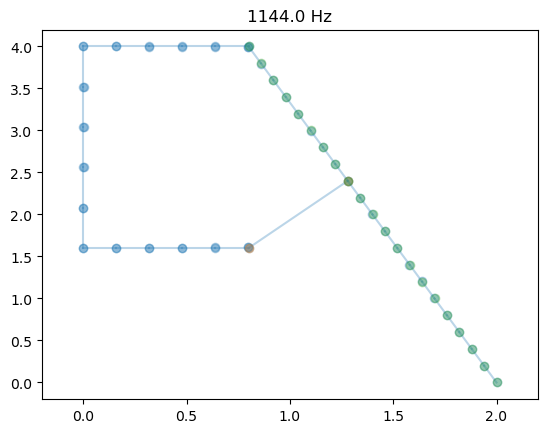

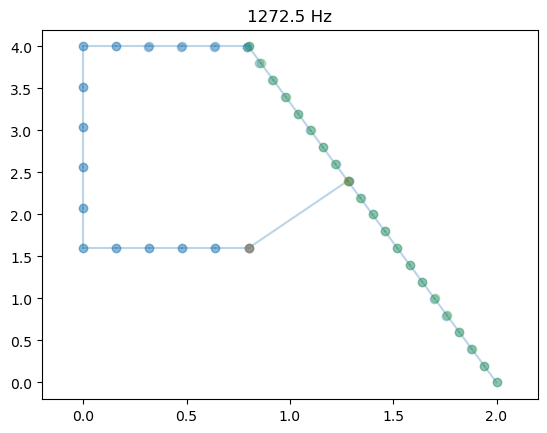

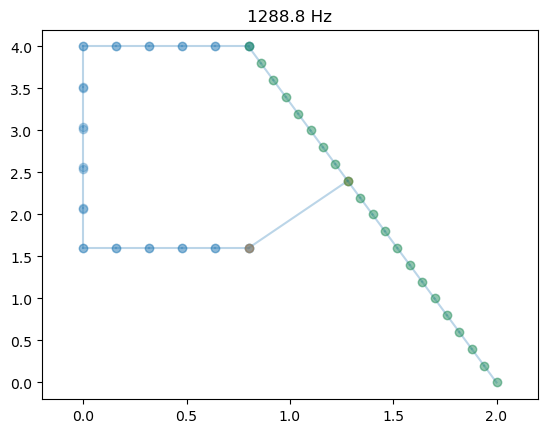

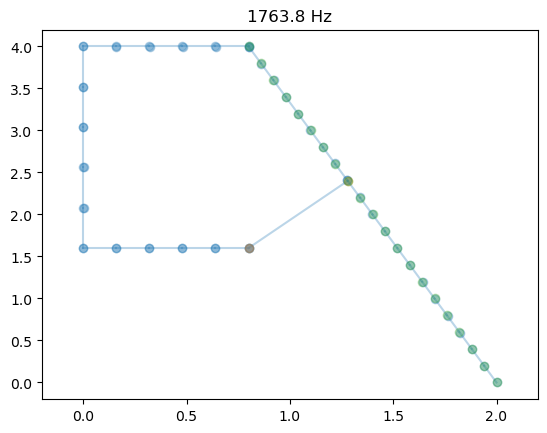

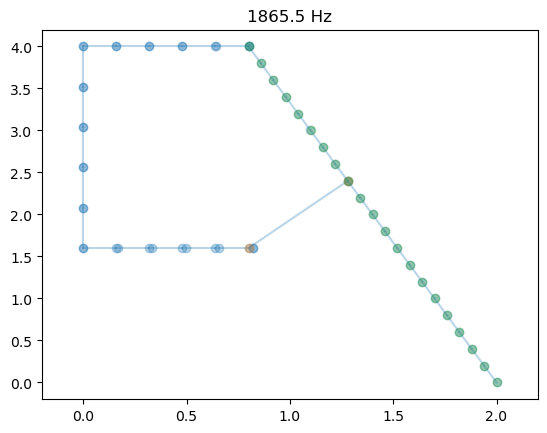

In [139]:
# m = 2
for m in np.arange(10):
    s = 0.8

    # podstruktura A
    pomiki_x_A = eig_vec_A[0::3,m].real
    pomiki_y_A = eig_vec_A[1::3,m].real

    # podstruktura B
    pomiki_x_B = eig_vec_B[0::2,m].real
    pomiki_y_B = eig_vec_B[1::2,m].real

    # podstruktura C
    pomiki_x_C = eig_vec_C[0::3,m].real
    pomiki_y_C = eig_vec_C[1::3,m].real

    def_vozlisca_A = np.copy(vozlisca_A)
    def_vozlisca_A[:,0] += pomiki_x_A *s
    def_vozlisca_A[:,1] += pomiki_y_A * s

    def_vozlisca_B = np.copy(vozlisca_B)
    def_vozlisca_B[:,0] += pomiki_x_B *s
    def_vozlisca_B[:,1] += pomiki_y_B * s

    def_vozlisca_C = np.copy(vozlisca_C)
    def_vozlisca_C[:,0] += pomiki_x_C *s
    def_vozlisca_C[:,1] += pomiki_y_C * s

    # Define the undeformed and deformed coordinates
    undeformed_coords_A = vozlisca_A
    deformed_coords_A = def_vozlisca_A

    undeformed_coords_B = vozlisca_B
    deformed_coords_B = def_vozlisca_B

    undeformed_coords_C = vozlisca_C
    deformed_coords_C = def_vozlisca_C

    undeformed_coords = np.vstack((vozlisca_A, vozlisca_B, vozlisca_C))
    deformed_coords = np.vstack((def_vozlisca_A, def_vozlisca_B, def_vozlisca_C))
    # undeformed_coords.shape, deformed_coords.shape

    # # Calculate the deformation array
    deformation = np.array(deformed_coords) - np.array(undeformed_coords)
    # deformation.shape

    # # Define the number of frames for each deformation direction
    n_frames = 20

    # # Define the animation direction sequence
    directions = [1, -1]

    # # Create a figure and axis object
    fig, ax = plt.subplots()
    ax.set_title(f'{eig_freq[m].round(1)} Hz')
    [ax.plot(vozlisca_A[[i,j],0],vozlisca_A[[i,j],1],'-',c='C0', alpha=0.3) for i,j in elementi_A]
    ax.plot(vozlisca_A[:,0],vozlisca_A[:,1],'o', alpha=0.3);
    [ax.plot(vozlisca_B[[i,j],0],vozlisca_B[[i,j],1],'-',c='C1', alpha=0.3) for i,j in elementi_B]
    ax.plot(vozlisca_B[:,0],vozlisca_B[:,1],'o', alpha=0.3);
    [ax.plot(vozlisca_C[[i,j],0],vozlisca_C[[i,j],1],'-',c='C2', alpha=0.3) for i,j in elementi_C]
    ax.plot(vozlisca_C[:,0],vozlisca_C[:,1],'o', alpha=0.3);

    # Set the axis limits
    ax.set_xlim([-0.2, 2.2])
    ax.set_ylim([-0.2, 4.2])

    # # Create a scatter plot of the undeformed coordinates
    # scatter = ax.scatter([c[0] for c in undeformed_coords], [c[1] for c in undeformed_coords], alpha=0.3)

    # Define the update function for the animation
    def update(frame):
        # Calculate the current deformation factor based on the current frame and direction
        direction = directions[frame // (2 * n_frames)]
        frame = frame % (2 * n_frames)
        alpha = frame / n_frames if frame < n_frames else (2 * n_frames - frame) / n_frames
        factor = direction * alpha
        
        # Calculate the current coordinates based on the current deformation factor
        coords = [[u[0] + factor * d[0], u[1] + factor * d[1]] for u, d in zip(undeformed_coords, deformation)]
        
        # Update the scatter plot with the current coordinates
        scatter.set_offsets(coords)
        
        # Return the scatter plot for this frame
        return scatter,

    # Define the total number of frames for the animations
    total_frames = 4 * n_frames

    # Create the animation object
    animation = FuncAnimation(fig, update, frames=total_frames, interval=50);

    # Save the animation as a GIF
    animation.save(f'deformation_{m}.gif', writer='imagemagick')
    print(f'GIF {m} ustvarjen!')


In [148]:
vozlisca_A.shape[0]

16

In [ ]:
# m = 2
for m in np.arange(1):
    s = 0.8

    # podstruktura A
    pomiki_x_A = eig_vec_A[0::3,m].real
    pomiki_y_A = eig_vec_A[1::3,m].real

    # podstruktura B
    pomiki_x_B = eig_vec_B[0::2,m].real
    pomiki_y_B = eig_vec_B[1::2,m].real

    # podstruktura C
    pomiki_x_C = eig_vec_C[0::3,m].real
    pomiki_y_C = eig_vec_C[1::3,m].real

    def_vozlisca_A = np.copy(vozlisca_A)
    def_vozlisca_A[:,0] += pomiki_x_A *s
    def_vozlisca_A[:,1] += pomiki_y_A * s

    def_vozlisca_B = np.copy(vozlisca_B)
    def_vozlisca_B[:,0] += pomiki_x_B *s
    def_vozlisca_B[:,1] += pomiki_y_B * s

    def_vozlisca_C = np.copy(vozlisca_C)
    def_vozlisca_C[:,0] += pomiki_x_C *s
    def_vozlisca_C[:,1] += pomiki_y_C * s

    # Define the undeformed and deformed coordinates
    undeformed_coords_A = vozlisca_A
    deformed_coords_A = def_vozlisca_A

    undeformed_coords_B = vozlisca_B
    deformed_coords_B = def_vozlisca_B

    undeformed_coords_C = vozlisca_C
    deformed_coords_C = def_vozlisca_C

    undeformed_coords = np.vstack((vozlisca_A, vozlisca_B, vozlisca_C))
    deformed_coords = np.vstack((def_vozlisca_A, def_vozlisca_B, def_vozlisca_C))
    # undeformed_coords.shape, deformed_coords.shape

    # # Calculate the deformation array
    deformation = np.array(deformed_coords) - np.array(undeformed_coords)
    # deformation.shape

    # # Define the number of frames for each deformation direction
    n_frames = 20

    # # Define the animation direction sequence
    directions = [1, -1]

    # # Create a figure and axis object
    fig, ax = plt.subplots()
    ax.set_title(f'{eig_freq[m].round(1)} Hz')
    [ax.plot(vozlisca_A[[i,j],0],vozlisca_A[[i,j],1],'-',c='C0', alpha=0.3) for i,j in elementi_A]
    ax.plot(vozlisca_A[:,0],vozlisca_A[:,1],'o', alpha=0.3);
    [ax.plot(vozlisca_B[[i,j],0],vozlisca_B[[i,j],1],'-',c='C1', alpha=0.3) for i,j in elementi_B]
    ax.plot(vozlisca_B[:,0],vozlisca_B[:,1],'o', alpha=0.3);
    [ax.plot(vozlisca_C[[i,j],0],vozlisca_C[[i,j],1],'-',c='C2', alpha=0.3) for i,j in elementi_C]
    ax.plot(vozlisca_C[:,0],vozlisca_C[:,1],'o', alpha=0.3);

    # Set the axis limits
    ax.set_xlim([-0.2, 2.2])
    ax.set_ylim([-0.2, 4.2])

    # # Create a scatter plot of the undeformed coordinates
    # scatter = ax.scatter([c[0] for c in undeformed_coords], [c[1] for c in undeformed_coords], alpha=0.3)

    # Define the update function for the animation
    def update(frame):
        # Calculate the current deformation factor based on the current frame and direction
        direction = directions[frame // (2 * n_frames)]
        frame = frame % (2 * n_frames)
        alpha = frame / n_frames if frame < n_frames else (2 * n_frames - frame) / n_frames
        factor = direction * alpha
        
        # Calculate the current coordinates based on the current deformation factor
        coords = [[u[0] + factor * d[0], u[1] + factor * d[1]] for u, d in zip(undeformed_coords, deformation)]
        
        # Update the scatter plot with the current coordinates
        scatter.set_offsets(coords)
        deformed_coords_A = coords[:vozlisca_A.shape[0], :]
        deformed_coords_B = coords[vozlisca_A.shape[0]:vozlisca_B.shape[0], :]
        deformed_coords_C = coords[-vozlisca_C.shape[0]:, :]
        [ax.plot(deformed_coords_A[[i,j],0],deformed_coords_A[[i,j],1],'-',c='C0', alpha=1) for i,j in elementi_A]
        ax.plot(deformed_coords_A[:,0],deformed_coords_A[:,1],'x', alpha=1);
        [ax.plot(deformed_coords_B[[i,j],0],deformed_coords_B[[i,j],1],'-',c='C1', alpha=1) for i,j in elementi_B]
        ax.plot(deformed_coords_B[:,0],deformed_coords_B[:,1],'x', alpha=1);
        [ax.plot(deformed_coords_C[[i,j],0],deformed_coords_C[[i,j],1],'-',c='C2', alpha=1) for i,j in elementi_C]
        ax.plot(deformed_coords_C[:,0],deformed_coords_C[:,1],'x', alpha=1);
        # Return the scatter plot for this frame
        return scatter,

    # Define the total number of frames for the animations
    total_frames = 4 * n_frames

    # Create the animation object
    animation = FuncAnimation(fig, update, frames=total_frames, interval=50);

    # Save the animation as a GIF
    animation.save(f'S_{m}.gif', writer='imagemagick')
    print(f'GIF {m} ustvarjen!')


MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: list index out of range

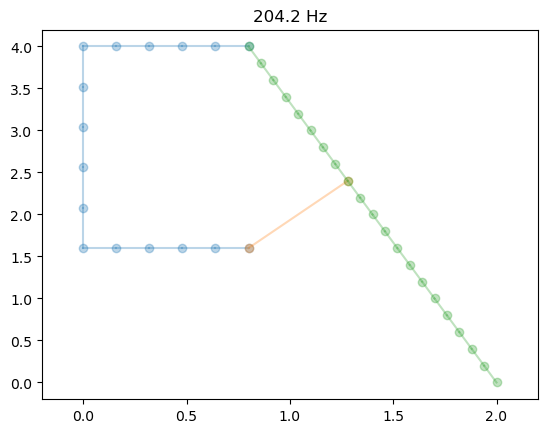

In [150]:
# m = 2
for m in np.arange(1):
    s = 0.8

    # podstruktura A
    pomiki_x_A = eig_vec_A[0::3,m].real
    pomiki_y_A = eig_vec_A[1::3,m].real

    # podstruktura B
    pomiki_x_B = eig_vec_B[0::2,m].real
    pomiki_y_B = eig_vec_B[1::2,m].real

    # podstruktura C
    pomiki_x_C = eig_vec_C[0::3,m].real
    pomiki_y_C = eig_vec_C[1::3,m].real

    def_vozlisca_A = np.copy(vozlisca_A)
    def_vozlisca_A[:,0] += pomiki_x_A *s
    def_vozlisca_A[:,1] += pomiki_y_A * s

    def_vozlisca_B = np.copy(vozlisca_B)
    def_vozlisca_B[:,0] += pomiki_x_B *s
    def_vozlisca_B[:,1] += pomiki_y_B * s

    def_vozlisca_C = np.copy(vozlisca_C)
    def_vozlisca_C[:,0] += pomiki_x_C *s
    def_vozlisca_C[:,1] += pomiki_y_C * s

    # Define the undeformed and deformed coordinates
    undeformed_coords_A = vozlisca_A
    deformed_coords_A = def_vozlisca_A

    undeformed_coords_B = vozlisca_B
    deformed_coords_B = def_vozlisca_B

    undeformed_coords_C = vozlisca_C
    deformed_coords_C = def_vozlisca_C

    undeformed_coords = np.vstack((vozlisca_A, vozlisca_B, vozlisca_C))
    deformed_coords = np.vstack((def_vozlisca_A, def_vozlisca_B, def_vozlisca_C))
    # undeformed_coords.shape, deformed_coords.shape

    # # Calculate the deformation array
    deformation = np.array(deformed_coords) - np.array(undeformed_coords)
    # deformation.shape

    # # Define the number of frames for each deformation direction
    n_frames = 20

    # # Define the animation direction sequence
    directions = [1, -1]

    # # Create a figure and axis object
    fig, ax = plt.subplots()
    ax.set_title(f'{eig_freq[m].round(1)} Hz')
    [ax.plot(vozlisca_A[[i,j],0],vozlisca_A[[i,j],1],'-',c='C0', alpha=0.3) for i,j in elementi_A]
    ax.plot(vozlisca_A[:,0],vozlisca_A[:,1],'o', alpha=0.3);
    [ax.plot(vozlisca_B[[i,j],0],vozlisca_B[[i,j],1],'-',c='C1', alpha=0.3) for i,j in elementi_B]
    ax.plot(vozlisca_B[:,0],vozlisca_B[:,1],'o', alpha=0.3);
    [ax.plot(vozlisca_C[[i,j],0],vozlisca_C[[i,j],1],'-',c='C2', alpha=0.3) for i,j in elementi_C]
    ax.plot(vozlisca_C[:,0],vozlisca_C[:,1],'o', alpha=0.3);

    # Set the axis limits
    ax.set_xlim([-0.2, 2.2])
    ax.set_ylim([-0.2, 4.2])

    # # Create a scatter plot of the undeformed coordinates
    # scatter = ax.scatter([c[0] for c in undeformed_coords], [c[1] for c in undeformed_coords], alpha=0.3)

    # Define the update function for the animation
    def update(frame):
        # Calculate the current deformation factor based on the current frame and direction
        direction = directions[frame // (2 * n_frames)]
        frame = frame % (2 * n_frames)
        alpha = frame / n_frames if frame < n_frames else (2 * n_frames - frame) / n_frames
        factor = direction * alpha
        
        # Calculate the current coordinates based on the current deformation factor
        coords = [[u[0] + factor * d[0], u[1] + factor * d[1]] for u, d in zip(undeformed_coords, deformation)]
        
        # Update the scatter plot with the current coordinates
        scatter.set_offsets(coords)
        deformed_coords_A = coords[:vozlisca_A.shape[0], :]
        deformed_coords_B = coords[vozlisca_A.shape[0]:vozlisca_B.shape[0], :]
        deformed_coords_C = coords[-vozlisca_C.shape[0]:, :]
        [ax.plot(deformed_coords_A[[i,j],0],deformed_coords_A[[i,j],1],'-',c='C0', alpha=1) for i,j in elementi_A]
        ax.plot(deformed_coords_A[:,0],deformed_coords_A[:,1],'x', alpha=1);
        [ax.plot(deformed_coords_B[[i,j],0],deformed_coords_B[[i,j],1],'-',c='C1', alpha=1) for i,j in elementi_B]
        ax.plot(deformed_coords_B[:,0],deformed_coords_B[:,1],'x', alpha=1);
        [ax.plot(deformed_coords_C[[i,j],0],deformed_coords_C[[i,j],1],'-',c='C2', alpha=1) for i,j in elementi_C]
        ax.plot(deformed_coords_C[:,0],deformed_coords_C[:,1],'x', alpha=1);
        # Return the scatter plot for this frame
        return scatter,

    # Define the total number of frames for the animations
    total_frames = 4 * n_frames

    # Create the animation object
    animation = FuncAnimation(fig, update, frames=total_frames, interval=50);

    # Save the animation as a GIF
    animation.save(f'S_{m}.gif', writer='imagemagick')
    print(f'GIF {m} ustvarjen!')


In [140]:
# # m = 2
# for m in np.arange(10):
#     s = 0.8

#     pomiki_x_A = eig_vec_A[0::3,m].real
#     pomiki_y_A = eig_vec_A[1::3,m].real

#     # podstruktura B
#     pomiki_x_C = eig_vec_C[0::3,m].real
#     pomiki_y_C = eig_vec_C[1::3,m].real

#     def_vozlisca_A = np.copy(vozlisca_A)
#     def_vozlisca_A[:,0] += pomiki_x_A *s
#     def_vozlisca_A[:,1] += pomiki_y_A * s

#     def_vozlisca_C = np.copy(vozlisca_C)
#     def_vozlisca_C[:,0] += pomiki_x_C *s
#     def_vozlisca_C[:,1] += pomiki_y_C * s

#     # Define the undeformed and deformed coordinates
#     undeformed_coords_A = vozlisca_A
#     deformed_coords_A = def_vozlisca_A
    
#     undeformed_coords_C = vozlisca_C
#     deformed_coords_C = def_vozlisca_C
    
#     undeformed_coords = np.vstack((vozlisca_A, vozlisca_C))
#     deformed_coords = np.vstack((def_vozlisca_A, def_vozlisca_C))

#     # Calculate the deformation array
#     deformation = np.array(deformed_coords) - np.array(undeformed_coords)

#     # Define the number of frames for each deformation direction
#     n_frames = 50

#     # Define the animation direction sequence
#     directions = [1, -1]

#     # Create a figure and axis object
#     fig, ax = plt.subplots()
#     ax.set_title(f'{eig_freq[m].round(1)} Hz')
#     [ax.plot(vozlisca_A[[i,j],0],vozlisca_A[[i,j],1],'-',c='C0', alpha=0.3) for i,j in elementi_A]
#     ax.plot(vozlisca_A[:,0],vozlisca_A[:,1],'o', alpha=0.3);

#     # Set the axis limits
#     ax.set_xlim([-0.2, 2.2])
#     ax.set_ylim([-0.2, 4.2])

#     # Create a scatter plot of the undeformed coordinates
#     # scatter = ax.scatter([c[0] for c in undeformed_coords], [c[1] for c in undeformed_coords])

#     # Define the update function for the animation
#     def update(frame):
#         # Calculate the current deformation factor based on the current frame and direction
#         direction = directions[frame // (2 * n_frames)]
#         frame = frame % (2 * n_frames)
#         alpha = frame / n_frames if frame < n_frames else (2 * n_frames - frame) / n_frames
#         factor = direction * alpha
        
#         # Calculate the current coordinates based on the current deformation factor
#         coords = [[u[0] + factor * d[0], u[1] + factor * d[1]] for u, d in zip(undeformed_coords, deformation)]
        
#         # Update the scatter plot with the current coordinates
#         scatter.set_offsets(coords)
        
#         # Return the scatter plot for this frame
#         return scatter,

#     # Define the total number of frames for the animations
#     total_frames = 4 * n_frames

#     # Create the animation object
#     animation = FuncAnimation(fig, update, frames=total_frames, interval=10);

#     # Save the animation as a GIF
#     animation.save(f'deformation_{m}.gif', writer='imagemagick')
#     print(f'GIF {m} ustvarjen!')
